### Model Err - looking at residual in detail
match the fastai-calcs for residuals

calculate the average-prediction

benchmark the error rate of average-prediction

extract the error-metric from a loaded-model

In [1]:
import os, sys, json, copy, random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from fastai.vision import *
from fastai.utils.mem import  gpu_mem_get_free_no_cache

%reload_ext autoreload
%autoreload 2
from modules.ap3graph import *
from modules.ap3data import build_data, get_truth_df, avg_prediction

gpu_mem_get_free_no_cache()

0

##### Build average prediction

In [2]:
data = build_data()

avg_prediction(data, as_flat=True, as_int=True)

[335, 540, 355, 724, 599, 718, 583, 530]

In [3]:
avg_points = avg_prediction(data)
avg_points

[[335.21707421707424, 540.8318318318318],
 [355.0280995280995, 724.021879021879],
 [599.7310167310168, 718.0083655083655],
 [583.3659373659374, 530.7074217074218]]

##### Plot average prediction
it works pretty well for some images

In [4]:
img0 = data.valid_dl.x.get(0)

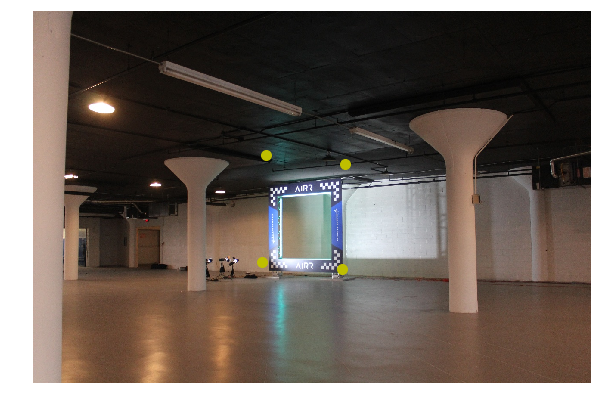

In [8]:
img0.show(y= get_ip(img0, tensor(avg_points)), figsize=(10,10)
         ,c='y' ,marker='o', s=100)

##### MSE matching
base-level code to emulate the residuals returned by fastai routines

In [26]:
import torch

# load a model to get_preds()
data_size288_bs32 = build_data(size=(288, 432), batch_size=32)
learn_50 = cnn_learner(data_size288_bs32, models.resnet50)
_ = learn_50.load('ap4-resnet50-1')

# preds - (predict, target, err)
preds = learn_50.get_preds(n_batch=1, with_loss=True)

In [226]:
all_preds = learn_50.get_preds(n_batch=None, with_loss=True)

In [227]:
len(all_preds[0])

1165

In [172]:
# build "synthetic" loss with torch classes
# ??torch.nn.MSELoss
loss_each_ = torch.nn.MSELoss(reduction='none')
loss_all_ = torch.nn.MSELoss(reduction='sum')

syn_err_each = [loss_each_(_pred, _target.flatten()) 
                for _pred, _target in zip(preds[0], preds[1]) ]
              

syn_err_all = [loss_all_(_pred, _target.flatten()) 
                for _pred, _target in zip(preds[0], preds[1]) ]

In [173]:
# convert to flat tensor
t_syn_each = tensor([e.tolist() for e in syn_err_each])
t_syn_each = t_syn_each.flatten()

In [193]:
sum(syn_err_all)

tensor(0.3767)

In [197]:
def calc_loss(pred, target):
    '''return tensor-len-1 for '''
    syn_err = [loss_all_(_pred, _target.flatten()) 
                    for _pred, _target in zip(pred, target) ]
    return sum(syn_err)
calc_loss(preds[0], preds[1])

tensor(0.3767)

In [239]:
#no, this is for `ap4-resnet50-1`, below is wrong, we don't know the mod err
#XXXfrom epoch printout in alphapilot-4.ipynb in model `ap4-big-1:
# XXX train-err,  valid-err
# XXX 0.016133, 0.009166
pred_all, target_all = all_preds[0], all_preds[1]
cl = calc_loss(pred_all, target_all) / len(pred_all)
cl

tensor(0.0289)

In [240]:
cl / 0.009166

tensor(3.1482)

In [174]:
#diff syntheitc against get_preds() output
diff1 = [a - b for a,b in zip(preds1[2], t_syn_each)]

In [185]:
# all elements match, sums match
print(
max(diff1), diff1[:4], '\n',
sum(preds[2]), sum(t_syn_each)
)

tensor(0.) [tensor(0.), tensor(0.), tensor(0.), tensor(0.)] 
 tensor(0.3767) tensor(0.3767)


In [189]:
# a diff with tensor operation
diff2 = t_syn_each - preds[2]
max(diff2)

tensor(0.)

In [190]:
# a very manual calculation of mse one first record
print((preds[0][0] - preds[1][0].flatten()) ** 2)
print(preds[2][:8])

tensor([1.4956e-06, 1.0555e-03, 1.3212e-04, 5.4638e-04, 6.0687e-05, 2.4307e-04,
        1.1889e-04, 9.0982e-04])
tensor([1.4956e-06, 1.0555e-03, 1.3212e-04, 5.4638e-04, 6.0687e-05, 2.4307e-04,
        1.1889e-04, 9.0982e-04])


##### Becnhmark avg_predictions

In [218]:
def calc_loss_avg(pred_avg, target):
    '''return tensor-len-1 for sum of residuals
        is this MSE or SSE?
    '''
    syn_err = [loss_all_(pred_avg, _target.flatten()) 
                    for _target in target ]
    return sum(syn_err)

In [219]:
pred_origin_coords = tensor([0.,0.],[0.,0.],[0.,0.],[0.,0.])
my_flow = FlowField(size=img0.shape[1:], flow=pred_origin_coords,)
my_ip = ImagePoints(flow=my_flow)
pred_origin = my_ip.data.flatten()
calc_loss_avg(pred_origin, preds[1])

tensor(305.1809)

In [220]:
pred_avg_coords = tensor(avg_prediction(data, as_flat=False, as_int=False))
my_flow = FlowField(size=img0.shape[1:], flow=pred_avg_coords,)
my_ip = ImagePoints(flow=my_flow)
pred_avg = my_ip.data.flatten()
calc_loss_avg(pred_avg, preds[1])

tensor(9.1939)

In [222]:
#error from
calc_loss(preds[0],preds[1])

tensor(0.3767)

In [225]:
0.37/32*8

0.0925

In [223]:
#so pred_origin -> pred_avg :: pred_avg -> pred_model
# a roughlyn 30x imporvement for each stage
305/9.2, 9.2/0.38

(33.152173913043484, 24.210526315789473)

##### extract error saved in model

In [243]:
type(learn_50)

fastai.basic_train.Learner

In [244]:
doc(Learner)

In [247]:
model_summary(learn_50)

NameError: name 'model_summary' is not defined

In [249]:
dir(learn_50)

['TTA',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_test_writeable_path',
 'add_time',
 'backward',
 'bn_wd',
 'callback_fns',
 'callbacks',
 'clip_grad',
 'create_opt',
 'data',
 'destroy',
 'dl',
 'export',
 'fit',
 'fit_one_cycle',
 'freeze',
 'freeze_to',
 'get_preds',
 'init',
 'interpret',
 'layer_groups',
 'load',
 'loss_func',
 'lr_find',
 'lr_range',
 'metrics',
 'mixup',
 'model',
 'model_dir',
 'opt',
 'opt_func',
 'path',
 'pred_batch',
 'predict',
 'purge',
 'save',
 'show_results',
 'split',
 'summary',
 'to_fp16',
 'to_fp32',
 'train_bn',
 'true_wd',
 'tta_only'

In [246]:
learn_50.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (4662 items)
x: PointsItemList
Image (3, 288, 432),Image (3, 288, 432),Image (3, 288, 432),Image (3, 288, 432),Image (3, 288, 432)
y: PointsLabelList
ImagePoints (288, 432),ImagePoints (288, 432),ImagePoints (288, 432),ImagePoints (288, 432),ImagePoints (288, 432)
Path: c:\users\wsutt\desktop\files\alphapilot\Data_Training\Data_Training;

Valid: LabelList (1165 items)
x: PointsItemList
Image (3, 288, 432),Image (3, 288, 432),Image (3, 288, 432),Image (3, 288, 432),Image (3, 288, 432)
y: PointsLabelList
ImagePoints (288, 432),ImagePoints (288, 432),ImagePoints (288, 432),ImagePoints (288, 432),ImagePoints (288, 432)
Path: c:\users\wsutt\desktop\files\alphapilot\Data_Training\Data_Training;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
learn_50.

##### Try to convert image to matplotlib/np
it would be nice to view the axis-grid on display

In [13]:
img0_data = img0.data

In [14]:
type(img0_data)

torch.Tensor

In [15]:
img0_data.shape

torch.Size([3, 864, 1296])

In [16]:
img0_data[:,:3,:3]

tensor([[[0.0314, 0.0314, 0.0275],
         [0.0510, 0.0471, 0.0353],
         [0.0196, 0.0275, 0.0314]],

        [[0.0392, 0.0392, 0.0353],
         [0.0588, 0.0549, 0.0431],
         [0.0275, 0.0353, 0.0392]],

        [[0.0353, 0.0353, 0.0314],
         [0.0549, 0.0510, 0.0392],
         [0.0235, 0.0314, 0.0353]]])

In [18]:
img0_np = np.array(img0_data)

In [19]:
type(img0_np)

numpy.ndarray

In [20]:
img0_np.shape

(3, 864, 1296)

In [22]:
img0_np[:,:3,:3]

array([[[0.031373, 0.031373, 0.027451],
        [0.05098 , 0.047059, 0.035294],
        [0.019608, 0.027451, 0.031373]],

       [[0.039216, 0.039216, 0.035294],
        [0.058824, 0.054902, 0.043137],
        [0.027451, 0.035294, 0.039216]],

       [[0.035294, 0.035294, 0.031373],
        [0.054902, 0.05098 , 0.039216],
        [0.023529, 0.031373, 0.035294]]], dtype=float32)